### ***Goal of this notebook:***
#### The purpose of this notebook is to show the different ways implemented to associate cluster catalogs. It is designed to associate the halos in cosmoDC2 and the clusters detected by redMaPPer in cosmoDC2, but can be tuned to work with other catalogues. 

### ***Rationale:*** 
#### Associating detected clusters to true halos (or different type of detected clusters catalogs) is non trivial. Different methods exist and may lead to slightly different results. Here we show different association methods along general statistics. 

In [1]:
import GCRCatalogs

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM

from cluster_validation.opening_catalogs_functions import *
from cluster_validation.association_methods import *
from cluster_validation.plotting_functions import *
from cluster_validation.association_statistics import *

%matplotlib inline
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.rcParams.update({'font.size': 18})
#plt.rcParams['figure.figsize'] = [10, 8] for big figures

## 0 - Opening and read catalogs

#### **Function to open truth and detection catalogs**

In [2]:
#function to open truth and detection catalogs

RM_cat_name = 'cosmoDC2_v1.1.4_redmapper_v0.2.1py'
#DC2_cat_name = 'cosmoDC2_v1.1.4' 
DC2_cat_name = 'cosmoDC2_v1.0_9556'  #Smaller Catalog

min_richness = 20
min_halo_mass = 3e14 #Msun

cluster_data, member_data, truth_data, gc, gc_truth = \
    RM_DC2_cat_open(RM_cat_name,DC2_cat_name,min_richness, min_halo_mass, cluster_only=False)

#take only the halo
halo_data = truth_data[truth_data['is_central']==True]

/usr/local/py/envs/desc/lib/python3.8/site-packages/GCRCatalogs/register.py:394: UserWarning: `cosmoDC2_v1.1.4_redmapper_v0.2.1py` has been deprecated and may be removed in the future.
Use cosmoDC2_v1.1.4_redmapper_v0.5.7 instead
If your analysis requires this specific catalog, please open an issue at https://github.com/LSSTDESC/gcr-catalogs/issues
  warnings.warn(


In [3]:
min_richness = 25
    # Get the redMaPPer catalog
gc = GCRCatalogs.load_catalog(RM_cat_name)
    # Select out the cluster and member quantities into different lists
quantities = gc.list_all_quantities()
cluster_quantities = [q for q in quantities if 'member' not in q]
member_quantities = [q for q in quantities if 'member' in q]
    
    # Read in the cluster and member data
query = GCRCatalogs.GCRQuery('(richness > ' + str(min_richness) +')')
cluster_data = Table(gc.get_quantities(cluster_quantities, [query]))
member_data = Table(gc.get_quantities(member_quantities))


/usr/local/py/envs/desc/lib/python3.8/site-packages/GCRCatalogs/register.py:394: UserWarning: `cosmoDC2_v1.1.4_redmapper_v0.2.1py` has been deprecated and may be removed in the future.
Use cosmoDC2_v1.1.4_redmapper_v0.5.7 instead
If your analysis requires this specific catalog, please open an issue at https://github.com/LSSTDESC/gcr-catalogs/issues
  warnings.warn(


#### **General catalog properties**

In [4]:
print("Number of elements in the truth catalog = ", len(truth_data))
print("Number of halos in the truth catalog = ", len(halo_data))
print("Number of clusters in the detection catalog = ", len(cluster_data))

Number of elements in the truth catalog =  570
Number of halos in the truth catalog =  3
Number of clusters in the detection catalog =  3203


In [5]:
print("Cluster catalog sky area = ", gc.sky_area, "deg2")
print("Truth catalog sky area = ", gc_truth.sky_area, "deg2")

Cluster catalog sky area =  439.78987 deg2
Truth catalog sky area =  3.357174580844667 deg2


In [6]:
#define same cosmological parameters as in the truth catalog (cosmoDC2)
cosmo = gc_truth.cosmology

In [7]:
#check the cosmological parameters in the two catalogs
#print('Cosmo in truth catalog:', gc_truth.cosmology)
#print('Cosmo in detection catalog:', gc_truth.cosmology)

In [8]:
#gc_truth.halo_mass_def

In [9]:
#gc_truth.get_catalog_info()

In [10]:
#gc.get_catalog_info()

# 1 - basic visualization

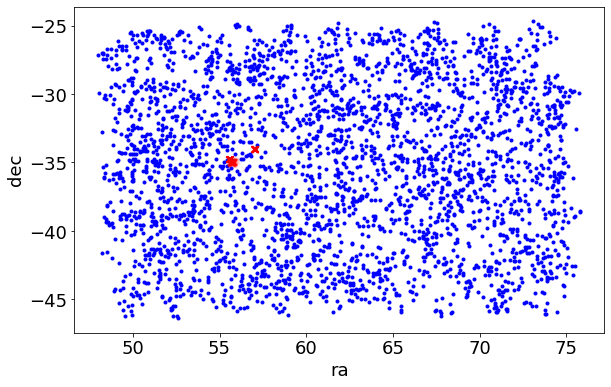

In [11]:
plt.plot(cluster_data['ra_cen_0'],cluster_data['dec_cen_0'],'b.')
plt.plot(truth_data['ra'],truth_data['dec'],'rx',alpha=0.1)
plt.xlabel("ra")
plt.ylabel("dec");

# 2 - associate Redmapper detections to true DC2 halos

**Association method scheme :**
- search for RM associations in a given cylinder around each DC2 object (radius $\theta_{max}$ and width $\Delta_z\times(1+z_{object})$)  
($\theta_{max}$  can be **fixed** - in Mpc or arcmin - **or scale** with halo mass and richness and $\Delta_z$ can be infinite)
- select the **nearest** match in projected distance **or** the one with the **more galaxies in common**
- repeat in the other direction (RM>DC2)
- return the associations which are bijective



### - 1rst association criteria : nearest within a cylinder with $\Delta_z=\inf, \theta_{max} = 1$ arcmin

In [12]:
#criteria
delta_zmax = np.inf
theta_max = 1. #arcmin
theta_max_type = "fixed_angle"
method = "nearest"

match_num_1w, match_num_2w, ind_bij = \
volume_match(halo_data, cluster_data, delta_zmax, theta_max, theta_max_type, method, cosmo, truth_data, member_data)
#truth_to_det_match_numbers, det_to_truth_match_number, bijective_match_indices

In [13]:
#statistics
print ("number of bijective associations", number_of_associations(ind_bij))
print ("number and fraction of fragmentation", fragmentation(match_num_1w, ind_bij, method="bij"))
print ("number and fraction of overmerging", overmerging(match_num_2w, ind_bij, method="bij"))
print ("completeness", completeness(halo_data, ind_bij, gc, gc_truth))
print ("purity", purity(cluster_data, ind_bij, gc, gc_truth))

number of bijective associations 3
number and fraction of fragmentation (0, 0.0)
number and fraction of overmerging (0, 0.0)
completeness 1.0
purity 0.12269747109553329


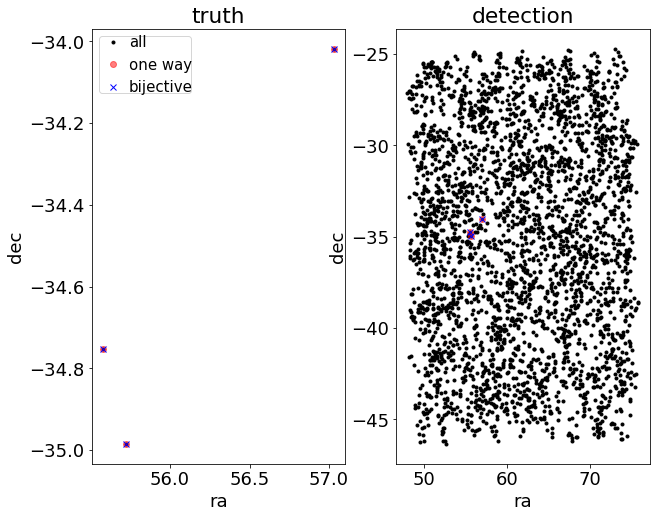

In [14]:
#check plot
f,a,b = plot_cluster_and_halo_position(halo_data, cluster_data, match_num_1w, match_num_2w, ind_bij)

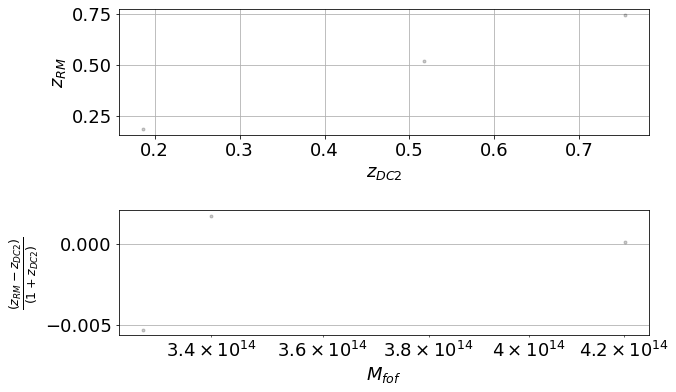

In [15]:
#plot to check redshift
plot_redshift_comparison(halo_data, cluster_data, ind_bij)

### - 2nd association criteria : nearest within a cylinder with $\Delta_z=0.05, \theta_{max} = 1 Mpc$ 

In [16]:
#criteria
delta_zmax = 0.05
theta_max = 1. #Mpc
theta_max_type = "fixed_dist"
method = "nearest"

match_num_1w, match_num_2w, ind_bij = \
volume_match(halo_data, cluster_data, delta_zmax, theta_max, theta_max_type, method, cosmo, truth_data, member_data)
#truth_to_det_match_numbers, det_to_truth_match_number, bijective_match_indices

In [17]:
#statistics
print ("number of bijective associations", number_of_associations(ind_bij))
print ("number and fraction of fragmentation", fragmentation(match_num_1w, ind_bij, method="bij"))
print ("number and fraction of overmerging", overmerging(match_num_2w, ind_bij, method="bij"))
print ("completeness", completeness(halo_data, ind_bij, gc, gc_truth))
print ("purity", purity(cluster_data, ind_bij, gc, gc_truth))

number of bijective associations 3
number and fraction of fragmentation (0, 0.0)
number and fraction of overmerging (0, 0.0)
completeness 1.0
purity 0.12269747109553329


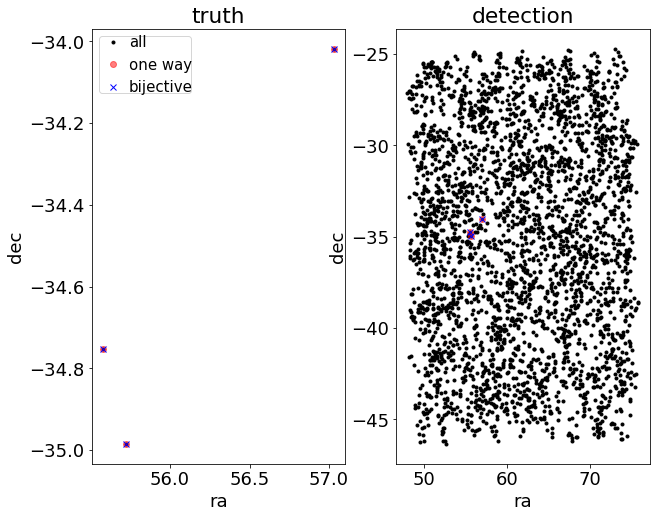

In [18]:
#check plot
f,a,b = plot_cluster_and_halo_position(halo_data, cluster_data, match_num_1w, match_num_2w, ind_bij)

### - 3rd association criteria : nearest within a cylinder with $\Delta_z=0.05, \theta_{max} = R(M_{halo}, \lambda_{cluster})$ 

In [16]:
#criteria
delta_zmax = 0.05
theta_max = 1. #Mpc
theta_max_type = "scaled"
method = "nearest"

match_num_1w, match_num_2w, ind_bij = \
volume_match(halo_data, cluster_data, delta_zmax, theta_max, theta_max_type, method, cosmo, truth_data, member_data)
#truth_to_det_match_numbers, det_to_truth_match_number, bijective_match_indices

In [17]:
#statistics
print ("number of bijective associations", number_of_associations(ind_bij))
print ("number and fraction of fragmentation", fragmentation(match_num_1w, ind_bij, method="bij"))
print ("number and fraction of overmerging", overmerging(match_num_2w, ind_bij, method="bij"))
print ("completeness", completeness(halo_data, ind_bij, gc, gc_truth))
print ("purity", purity(cluster_data, ind_bij, gc, gc_truth))

number of bijective associations 525
number and fraction of fragmentation (2, 0.0038095238095238095)
number and fraction of overmerging (29, 0.05523809523809524)
completeness 0.8522727274484028
purity 0.11010906040268456


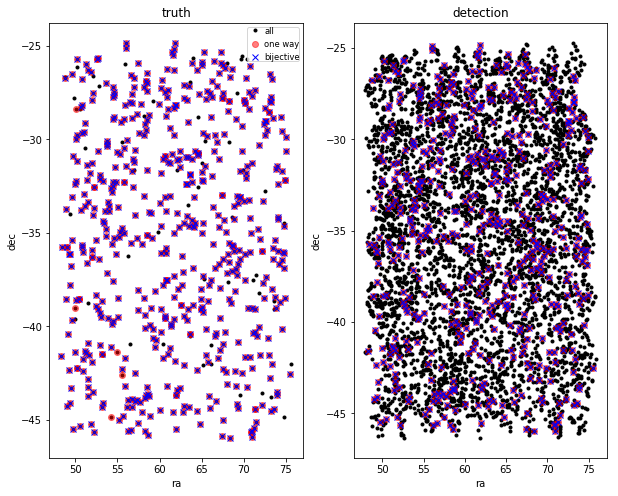

In [18]:
#check plot
f,a,b = plot_cluster_and_halo_position(halo_data, cluster_data, match_num_1w, match_num_2w, ind_bij)

### - 4rth association criteria : highest common membership within a cylinder with $\Delta_z=0.05, \theta_{max} = 1 Mpc$ 

In [19]:
#criteria
delta_zmax = 0.05
theta_max = 1. #Mpc
theta_max_type = "fixed_dist"
method = "membership"

match_num_1w, match_num_2w, ind_bij = \
volume_match(halo_data, cluster_data, delta_zmax, theta_max, theta_max_type, method, cosmo, truth_data, member_data)
#truth_to_det_match_numbers, det_to_truth_match_number, bijective_match_indices

In [20]:
#statistics
print ("number of bijective associations", number_of_associations(ind_bij))
print ("number and fraction of fragmentation", fragmentation(match_num_1w, ind_bij, method="bij"))
print ("number and fraction of overmerging", overmerging(match_num_2w, ind_bij, method="bij"))
print ("completeness", completeness(halo_data, ind_bij, gc, gc_truth))
print ("purity", purity(cluster_data, ind_bij, gc, gc_truth))

number of bijective associations 526
number and fraction of fragmentation (1, 0.0019011406844106464)
number and fraction of overmerging (29, 0.055133079847908745)
completeness 0.853896104072114
purity 0.11031879194630873


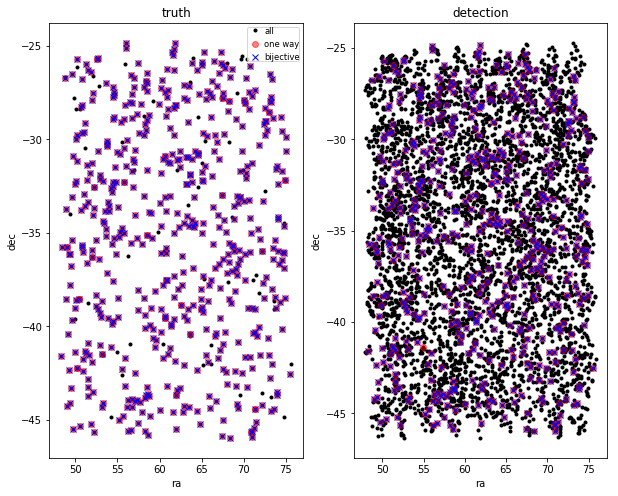

In [21]:
#check plot
f,a,b = plot_cluster_and_halo_position(halo_data, cluster_data, match_num_1w, match_num_2w, ind_bij)